## Project Description:
A project to recognize multi-digit numbers from photographs.

## Context:
Recognizing multi-digit numbers in photographs captured at street level is an important component of modern-day map making. A classic example of a corpus of such street-level photographs is Google’s Street View imagery comprised of hundreds of millions of geo-located 360-degree panoramic images. The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed
number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents. More broadly, recognizing numbers in photographs is a problem of interest to the optical
character recognition community. While OCR on constrained domains like document processing is well studied, arbitrary multi-character text recognition in photographs is still highly challenging. This difficulty arises due to the wide variability in the visual appearance of text in the wild on account of a large range of fonts, colours, styles, orientations, and character arrangements. The recognition problem is further complicated by environmental factors such as lighting, shadows, specularities, and occlusions as well as by image acquisition factors such as resolution, motion, and focus blurs. In this project, we will use the dataset with images centred around a single digit (many of the images do contain some distractors at the sides).



## Dataset:
SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with the minimal requirement on data formatting but comes from a significantly harder, unsolved, real-world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

**Acknowledgement:**
Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural
Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature
Learning 2011. PDF
http://ufldl.stanford.edu/housenumbers as the URL for this site when necessary

## Objective:
To learn how to implement a simple image classification pipeline based on a deep neural network and understand the basics of Image Classification. 

#### Import necessary libraries

In [1]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import tensorflow

from pprint import pprint

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History

## Read the dataset

In [4]:
from google.colab import drive

In [5]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Accessing the data file in read mode:
h5f = h5py.File('/content/gdrive/My Drive/AIML/Projects/SVHN_single_grey1.h5', 'r')

# Read data into variables: 
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Closing the file:
h5f.close()

In [7]:
# Printing the shape of Training, Test and Validation Dataset:
print(f'We have {X_train.shape[0]} training samples.')
print(f'We have {X_test.shape[0]} test samples.')
print(f'We have {X_val.shape[0]} validation samples.')

We have 42000 training samples.
We have 18000 test samples.
We have 60000 validation samples.


In [8]:
num_images = X_train.shape[0] + X_test.shape[0] + X_val.shape[0]
print("Total number of images = ", num_images)

Total number of images =  120000


Thus, in all we have 120000 images for our model.

## Visualising Images

In [9]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


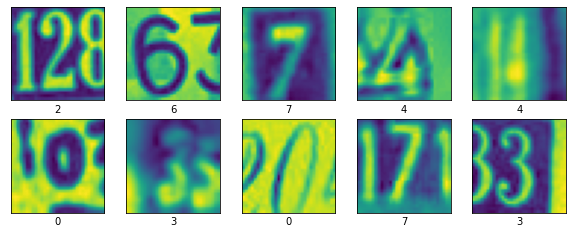

In [10]:
plt.figure(figsize = (10,10))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i])
  plt.xlabel(y_train[i])

## Reshape the features

In [11]:
print('Training set feature shape = ', X_train.shape, y_train.shape)
print('Test set feature shape = ', X_test.shape, y_test.shape)
print('Validation set feature shape = ', X_val.shape, y_val.shape)

Training set feature shape =  (42000, 32, 32) (42000,)
Test set feature shape =  (18000, 32, 32) (18000,)
Validation set feature shape =  (60000, 32, 32) (60000,)


We need to reshape the X_train, X_test and X_val so that the same can be fed for model building. We need to feed a 2D-Tensor to the model but currently our dataset is a 3D-Tensor.

In [12]:
X_train = X_train.reshape(X_train.shape[0], 1024, 1)
X_test = X_test.reshape(X_test.shape[0], 1024, 1)
X_val = X_val.reshape(X_val.shape[0], 1024, 1)

In [13]:
# Printing the shape of Training, Test and Validation Dataset:
print('Resized Training set feature shape = ', X_train.shape, y_train.shape)
print('Resized Test set feature shape = ', X_test.shape, y_test.shape)
print('Resized Validation set feature shape = ', X_val.shape, y_val.shape)

Resized Training set feature shape =  (42000, 1024, 1) (42000,)
Resized Test set feature shape =  (18000, 1024, 1) (18000,)
Resized Validation set feature shape =  (60000, 1024, 1) (60000,)


Thus, our dataset has been converted into a 2D-Tensor.

## Normalize the dataset

- We can normalize our dataset by dividing X_train, X_test and X_val by 255.0.

In [14]:
X_train = X_train/255.0
X_test = X_test/255.0
X_val = X_val/255.0

## Encoding the target variables

In [15]:
# As we know there are ten unique label in y axis so,
num_class = 10
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes = num_class)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes = num_class)
y_val = tensorflow.keras.utils.to_categorical(y_val, num_classes = num_class)

print('Training set:', y_train.shape)
print('Test set:', y_test.shape)
print('Validation set:', y_val.shape)

Training set: (42000, 10)
Test set: (18000, 10)
Validation set: (60000, 10)


Thus, here in all the sets we have 10 column in our y-axis where each column represents a label to which the image can be identified with

## Creating a Neural Network

Here we will be using Rectified Linear Unit (ReLU) as our activation function and Adam Optimizer to make our first basic model. Here we will be having 4 hidden layers each having 128 neurons.

In [16]:
epochs = 50
learning_rate = 0.001
input_dim = X_train.shape[1]

# Using Adam optimizer
adam = optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8)

In [17]:
# build the model

svhn_model = Sequential()
svhn_model.add(Flatten())
svhn_model.add(Dense(128, input_dim = input_dim))
svhn_model.add(Activation('relu'))
svhn_model.add(Dense(128, input_dim = input_dim))
svhn_model.add(Activation('relu'))
svhn_model.add(Dense(128, input_dim = input_dim))
svhn_model.add(Activation('relu'))
svhn_model.add(Dense(128, input_dim = input_dim))
svhn_model.add(Activation('relu'))
svhn_model.add(Dense(num_class))
svhn_model.add(Activation('softmax'))

# compile the model
svhn_model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [18]:
%%time
# Fit the model
batch_size = int(input_dim/100)

svhn_model_history = svhn_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (X_val, y_val))

Epoch 1/50
4200/4200 [==============================] - 17s 4ms/step - loss: 2.3039 - accuracy: 0.0988 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 2/50
4200/4200 [==============================] - 17s 4ms/step - loss: 2.3029 - accuracy: 0.1005 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/50
4200/4200 [==============================] - 16s 4ms/step - loss: 2.3029 - accuracy: 0.0986 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 4/50
4200/4200 [==============================] - 17s 4ms/step - loss: 2.3029 - accuracy: 0.0992 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 5/50
4200/4200 [==============================] - 17s 4ms/step - loss: 2.3029 - accuracy: 0.0960 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 6/50
4200/4200 [==============================] - 16s 4ms/step - loss: 2.3029 - accuracy: 0.0992 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/50
4200/4200 [==============================] - 16s 4ms/step - loss: 2.3029 - accuracy: 0.1001 - val_loss: 2.3026 - val_ac

In [19]:
%%time

results = svhn_model.evaluate(X_test, y_test)

563/563 [==============================] - 1s 2ms/step - loss: 2.3030 - accuracy: 0.0955
CPU times: user 1.31 s, sys: 72.4 ms, total: 1.38 s
Wall time: 1.17 s


In [20]:
print('The loss obtained on test set is = ', results[0])
print('The accuracy obtained by the model on test set is = ', results[1])

The loss obtained on test set is =  2.3029918670654297
The accuracy obtained by the model on test set is =  0.09549999982118607


Text(0.5, 1.0, 'Training and validation loss')

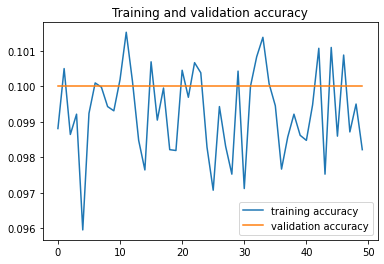

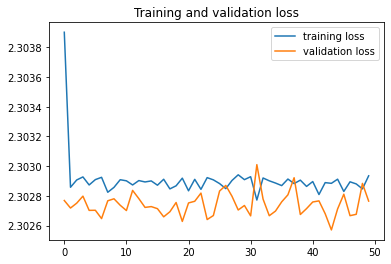

In [21]:
accuracy      = svhn_model_history.history['accuracy']
val_accuracy  = svhn_model_history.history['val_accuracy']
loss     = svhn_model_history.history['loss']
val_loss = svhn_model_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss')
plt.plot  ( epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

From both the above graph it is clear that the model obtained here works very poorly as the curve for validation accuracy has saturated at 10% for 50 epochs. 

Here, we can see that the **loss obtained by the model is high and the accuracy obtained is quite low**.

Now we will try to improve the accuracy obtained by the model by changing some of the parameters from the above model like by changing the learning rate, by changing the weights associated with neurons etc.

- Using a different **learning rate**

In [22]:
%%time
# solution
epochs = 50
learning_rate = 0.0001 # We have changed the learning rate from 0.001 to 0.0001

# define the optimizer function
adam = optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8)

input_dim = X_train.shape[1]

# build the model
svhn_model_lr = Sequential()
svhn_model_lr.add(Flatten())
svhn_model_lr.add(Dense(128, input_dim = input_dim))
svhn_model_lr.add(Activation('relu'))
svhn_model_lr.add(Dense(128, input_dim = input_dim))
svhn_model_lr.add(Activation('relu'))
svhn_model_lr.add(Dense(128, input_dim = input_dim))
svhn_model_lr.add(Activation('relu'))
svhn_model_lr.add(Dense(128, input_dim = input_dim))
svhn_model_lr.add(Activation('relu'))
svhn_model_lr.add(Dense(num_class))
svhn_model_lr.add(Activation('softmax'))

# compile the model
svhn_model_lr.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

# Fit the model
batch_size = int(input_dim/100)

svhn_model_lr_history = svhn_model_lr.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/50
4200/4200 [==============================] - 16s 4ms/step - loss: 2.0298 - accuracy: 0.2620 - val_loss: 1.5656 - val_accuracy: 0.4847
Epoch 2/50
4200/4200 [==============================] - 16s 4ms/step - loss: 1.4277 - accuracy: 0.5325 - val_loss: 1.3240 - val_accuracy: 0.5662
Epoch 3/50
4200/4200 [==============================] - 15s 4ms/step - loss: 1.2208 - accuracy: 0.6105 - val_loss: 1.1273 - val_accuracy: 0.6475
Epoch 4/50
4200/4200 [==============================] - 16s 4ms/step - loss: 1.0953 - accuracy: 0.6553 - val_loss: 1.0456 - val_accuracy: 0.6673
Epoch 5/50
4200/4200 [==============================] - 16s 4ms/step - loss: 1.0113 - accuracy: 0.6872 - val_loss: 0.9611 - val_accuracy: 0.7035
Epoch 6/50
4200/4200 [==============================] - 16s 4ms/step - loss: 0.9450 - accuracy: 0.7080 - val_loss: 0.9109 - val_accuracy: 0.7197
Epoch 7/50
4200/4200 [==============================] - 16s 4ms/step - loss: 0.9003 - accuracy: 0.7223 - val_loss: 0.8949 - val_ac

In [23]:
%%time

results_lr = svhn_model_lr.evaluate(X_test, y_test)

563/563 [==============================] - 1s 2ms/step - loss: 0.6656 - accuracy: 0.8092
CPU times: user 1.3 s, sys: 78.1 ms, total: 1.38 s
Wall time: 1.18 s


In [24]:
print('The loss obtained on test set is = ', results_lr[0])
print('The accuracy obtained by the model on test set is = ', results_lr[1])

The loss obtained on test set is =  0.6656255125999451
The accuracy obtained by the model on test set is =  0.809166669845581


Text(0.5, 1.0, 'Training and validation loss')

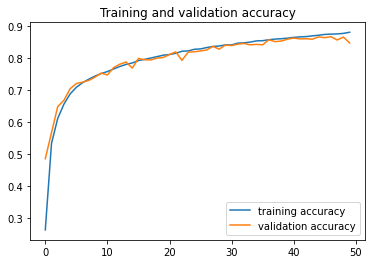

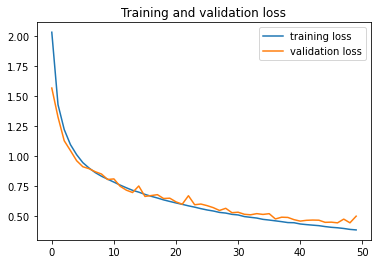

In [25]:
accuracy      = svhn_model_lr_history.history['accuracy']
val_accuracy  = svhn_model_lr_history.history['val_accuracy']
loss     = svhn_model_lr_history.history['loss']
val_loss = svhn_model_lr_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss')
plt.plot  ( epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(76.2, 0.5, 'True Values')

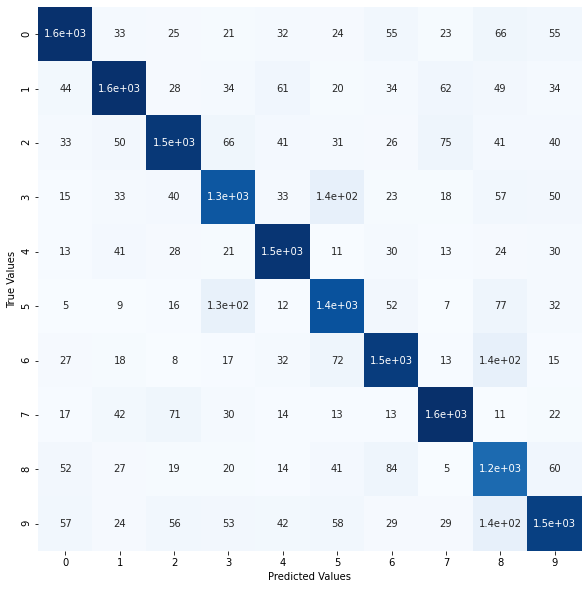

In [26]:
fig = plt.figure(figsize = (10,10))

y_pred_lr = svhn_model_lr.predict(X_test)

y_pred_lr = np.argmax(y_pred_lr, 1) #decode predicted labels
y_test_lr = np.argmax(y_test, 1) #decode labels

mat_lr = confusion_matrix(y_test_lr, y_pred_lr)

sns.heatmap(mat_lr.T, square = True, annot = True, cbar = False, cmap = plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

As we can see that the model (neural network with a weight initializer) has an accuracy of around 80.92%, so we have a quite huge improvement over the previous model.

From the classification matrix we can see that although the model predicts correctly for most of the digits, it also predicts some images incorrectly like 140 images as 5 when it actually was 3, 140 images as 8 when actually it was 6.  

Since, with learning rate = 0.0001 we got a much better performing model, so going forward we will be using 0.0001 as our learning rate.

- Using **he_normal** as weight initializer.

In [27]:
%%time
# solution
epochs = 50
learning_rate = 0.0001 

# define the optimizer function
adam = optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8)

input_dim = X_train.shape[1]

# build the model
svhn_model_he = Sequential()
svhn_model_he.add(Flatten())
svhn_model_he.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_he.add(Activation('relu'))
svhn_model_he.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_he.add(Activation('relu'))
svhn_model_he.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_he.add(Activation('relu'))
svhn_model_he.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_he.add(Activation('relu'))
svhn_model_he.add(Dense(num_class))
svhn_model_he.add(Activation('softmax'))

# compile the model
svhn_model_he.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

# Fit the model
batch_size = int(input_dim/100)

svhn_model_he_history = svhn_model_he.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/50
4200/4200 [==============================] - 16s 4ms/step - loss: 1.9416 - accuracy: 0.3161 - val_loss: 1.4291 - val_accuracy: 0.5470
Epoch 2/50
4200/4200 [==============================] - 16s 4ms/step - loss: 1.2809 - accuracy: 0.5958 - val_loss: 1.1775 - val_accuracy: 0.6278
Epoch 3/50
4200/4200 [==============================] - 17s 4ms/step - loss: 1.1122 - accuracy: 0.6504 - val_loss: 1.0790 - val_accuracy: 0.6609
Epoch 4/50
4200/4200 [==============================] - 18s 4ms/step - loss: 1.0174 - accuracy: 0.6848 - val_loss: 0.9779 - val_accuracy: 0.7003
Epoch 5/50
4200/4200 [==============================] - 15s 4ms/step - loss: 0.9418 - accuracy: 0.7062 - val_loss: 0.9425 - val_accuracy: 0.7039
Epoch 6/50
4200/4200 [==============================] - 16s 4ms/step - loss: 0.8849 - accuracy: 0.7268 - val_loss: 0.8802 - val_accuracy: 0.7237
Epoch 7/50
4200/4200 [==============================] - 16s 4ms/step - loss: 0.8420 - accuracy: 0.7397 - val_loss: 0.8470 - val_ac

In [28]:
%%time

results_he = svhn_model_he.evaluate(X_test, y_test)

563/563 [==============================] - 1s 2ms/step - loss: 0.6238 - accuracy: 0.8287
CPU times: user 1.23 s, sys: 61 ms, total: 1.3 s
Wall time: 1.1 s


In [29]:
print('The loss obtained on test set is = ', results_he[0])
print('The accuracy obtained by the model on test set is = ', results_he[1])

The loss obtained on test set is =  0.6238269209861755
The accuracy obtained by the model on test set is =  0.8287222385406494


Text(0.5, 1.0, 'Training and validation loss')

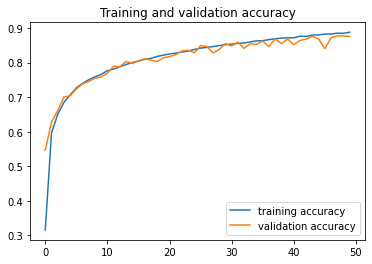

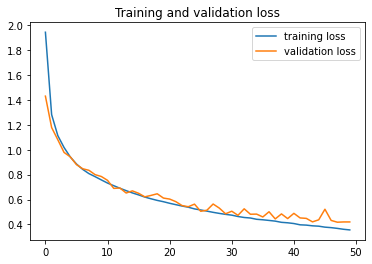

In [30]:
accuracy      = svhn_model_he_history.history['accuracy']
val_accuracy  = svhn_model_he_history.history['val_accuracy']
loss     = svhn_model_he_history.history['loss']
val_loss = svhn_model_he_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss')
plt.plot  ( epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(76.2, 0.5, 'True Values')

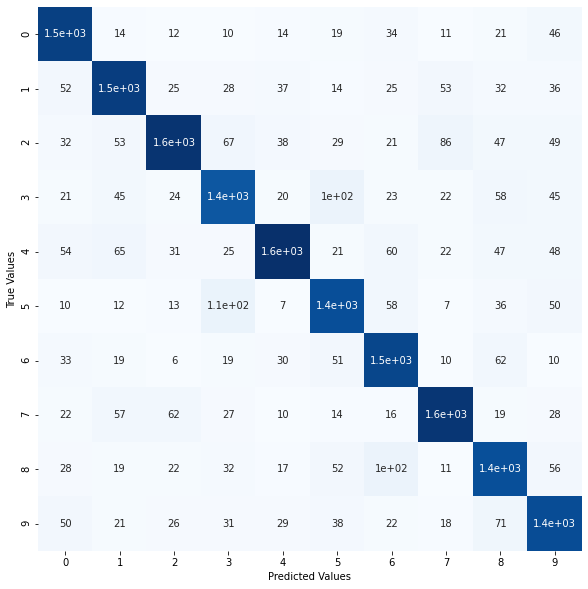

In [31]:
fig = plt.figure(figsize = (10,10))

y_pred_he = svhn_model_he.predict(X_test)

y_pred_he = np.argmax(y_pred_he, 1) #decode predicted labels
y_test_he = np.argmax(y_test, 1) #decode labels

mat_he = confusion_matrix(y_test_he, y_pred_he)

sns.heatmap(mat_he.T, square = True, annot = True, cbar = False, cmap = plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

As we can see that the model (neural network with a weight initializer) has an accuracy of around 82.87%, so we have a quite huge improvement over the simple neural model.

From the classification matrix we can see that although the model predicts correctly for most of the digits, it also predicts some images incorrectly like 100 images as 5 when it actually was 3, 110 images as 5 when actually it was 3, 100 images as 6 when actually it was 8.  

- Using a **decay learning rate**


In [32]:
%%time
# solution
epochs = 50
learning_rate = 0.0001 

# define the optimizer function
adam = optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8)

input_dim = X_train.shape[1]

# build the model
svhn_model_dr = Sequential()
svhn_model_dr.add(Flatten())
svhn_model_dr.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_dr.add(Activation('relu'))
svhn_model_dr.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_dr.add(Activation('relu'))
svhn_model_dr.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_dr.add(Activation('relu'))
svhn_model_dr.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_dr.add(Activation('relu'))
svhn_model_dr.add(Dense(num_class))
svhn_model_dr.add(Activation('softmax'))

# compile the model
svhn_model_dr.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

# define the learning rate change
def exp_decay(epoch):
  lrate = learning_rate * np.exp(-0.1*epoch)
  return lrate

# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

# Fit the model
batch_size = int(input_dim/100)

svhn_model_dr_history = svhn_model_dr.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks = callbacks_list, verbose = 1)

Epoch 1/50
4200/4200 [==============================] - 16s 4ms/step - loss: 1.9114 - accuracy: 0.3233 - val_loss: 1.4806 - val_accuracy: 0.5174
Epoch 2/50
4200/4200 [==============================] - 16s 4ms/step - loss: 1.3262 - accuracy: 0.5759 - val_loss: 1.2359 - val_accuracy: 0.6115
Epoch 3/50
4200/4200 [==============================] - 15s 4ms/step - loss: 1.1532 - accuracy: 0.6385 - val_loss: 1.0763 - val_accuracy: 0.6673
Epoch 4/50
4200/4200 [==============================] - 15s 4ms/step - loss: 1.0653 - accuracy: 0.6687 - val_loss: 1.0095 - val_accuracy: 0.6878
Epoch 5/50
4200/4200 [==============================] - 15s 4ms/step - loss: 1.0018 - accuracy: 0.6908 - val_loss: 0.9828 - val_accuracy: 0.6959
Epoch 6/50
4200/4200 [==============================] - 14s 3ms/step - loss: 0.9517 - accuracy: 0.7058 - val_loss: 0.9237 - val_accuracy: 0.7168
Epoch 7/50
4200/4200 [==============================] - 14s 3ms/step - loss: 0.9108 - accuracy: 0.7205 - val_loss: 0.9034 - val_ac

In [33]:
%%time

results_dr = svhn_model_dr.evaluate(X_test, y_test)

563/563 [==============================] - 1s 2ms/step - loss: 0.7394 - accuracy: 0.7816
CPU times: user 1.25 s, sys: 74.2 ms, total: 1.33 s
Wall time: 1.13 s


In [34]:
print('The loss obtained on test set is = ', results_dr[0])
print('The accuracy obtained by the model on test set is = ', results_dr[1])

The loss obtained on test set is =  0.739378035068512
The accuracy obtained by the model on test set is =  0.7816110849380493


Text(0.5, 1.0, 'Training and validation loss')

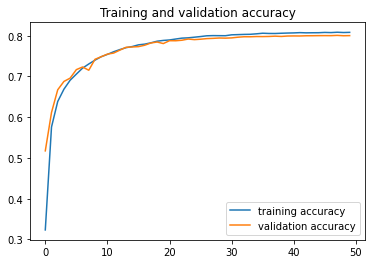

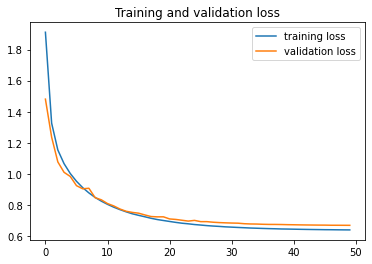

In [35]:
accuracy      = svhn_model_dr_history.history['accuracy']
val_accuracy  = svhn_model_dr_history.history['val_accuracy']
loss     = svhn_model_dr_history.history['loss']
val_loss = svhn_model_dr_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss')
plt.plot  ( epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(76.2, 0.5, 'True Values')

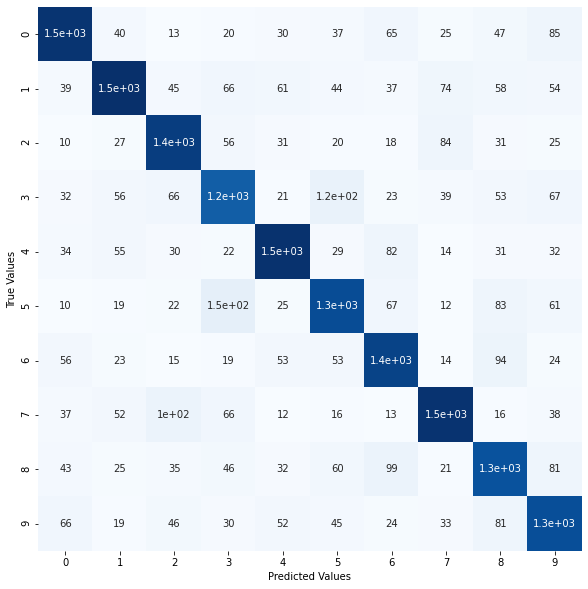

In [36]:
fig = plt.figure(figsize = (10,10))

y_pred_dr = svhn_model_dr.predict(X_test)

y_pred_dr = np.argmax(y_pred_dr, 1) #decode predicted labels
y_test_dr = np.argmax(y_test, 1) #decode labels

mat_dr = confusion_matrix(y_test_dr, y_pred_dr)

sns.heatmap(mat_dr.T, square = True, annot = True, cbar = False, cmap = plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

As we can see that the model (neural network with a weight initializer) has an accuracy of around 78.16%, so we have a quite huge improvement over the simple neural model.

From the classification matrix we can see that although the model predicts correctly for most of the digits, it also predicts some images incorrectly like 120 images as 5 when it actually was 3, 150 images as 3 when actually it was 5, 100 images as 2 when actually it was 7.  

- Using **Batch Normalization** 

In [37]:
%%time
# solution
epochs = 50
learning_rate = 0.0001 

# define the optimizer function
adam = optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8)

input_dim = X_train.shape[1]

# build the model
svhn_model_bn = Sequential()
svhn_model_bn.add(Flatten())
svhn_model_bn.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_bn.add(BatchNormalization())
svhn_model_bn.add(Activation('relu'))
svhn_model_bn.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_bn.add(BatchNormalization())
svhn_model_bn.add(Activation('relu'))
svhn_model_bn.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_bn.add(BatchNormalization())
svhn_model_bn.add(Activation('relu'))
svhn_model_bn.add(Dense(128, input_dim = input_dim, kernel_initializer = 'he_normal'))
svhn_model_bn.add(BatchNormalization())
svhn_model_bn.add(Activation('relu'))
svhn_model_bn.add(Dense(num_class))
svhn_model_bn.add(Activation('softmax'))

# compile the model
svhn_model_bn.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

# Fit the model
batch_size = int(input_dim/100)

svhn_model_bn_history = svhn_model_bn.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/50
4200/4200 [==============================] - 19s 5ms/step - loss: 2.0486 - accuracy: 0.2787 - val_loss: 1.5396 - val_accuracy: 0.4961
Epoch 2/50
4200/4200 [==============================] - 17s 4ms/step - loss: 1.5671 - accuracy: 0.4787 - val_loss: 1.2554 - val_accuracy: 0.5924
Epoch 3/50
4200/4200 [==============================] - 18s 4ms/step - loss: 1.3751 - accuracy: 0.5529 - val_loss: 1.2533 - val_accuracy: 0.5887
Epoch 4/50
4200/4200 [==============================] - 18s 4ms/step - loss: 1.2788 - accuracy: 0.5871 - val_loss: 1.0611 - val_accuracy: 0.6642
Epoch 5/50
4200/4200 [==============================] - 17s 4ms/step - loss: 1.2110 - accuracy: 0.6114 - val_loss: 1.1407 - val_accuracy: 0.6323
Epoch 6/50
4200/4200 [==============================] - 18s 4ms/step - loss: 1.1569 - accuracy: 0.6289 - val_loss: 0.9722 - val_accuracy: 0.6917
Epoch 7/50
4200/4200 [==============================] - 17s 4ms/step - loss: 1.1187 - accuracy: 0.6434 - val_loss: 0.9395 - val_ac

In [38]:
%%time
results_bn = svhn_model_bn.evaluate(X_test, y_test)

563/563 [==============================] - 1s 2ms/step - loss: 0.6109 - accuracy: 0.8158
CPU times: user 1.65 s, sys: 52.5 ms, total: 1.7 s
Wall time: 1.46 s


In [39]:
print('The loss obtained on test set is = ', results_bn[0])
print('The accuracy obtained by the model on test set is = ', results_bn[1])

The loss obtained on test set is =  0.6109386086463928
The accuracy obtained by the model on test set is =  0.815833330154419


Text(0.5, 1.0, 'Training and validation loss')

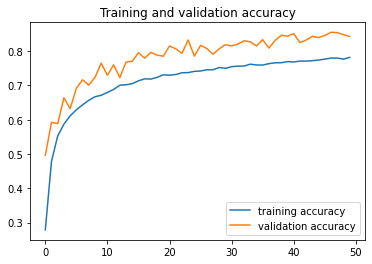

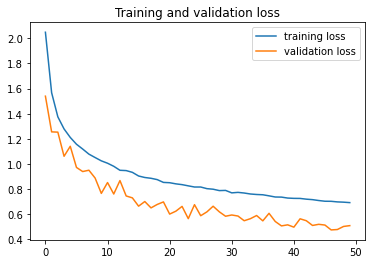

In [40]:
accuracy      = svhn_model_bn_history.history['accuracy']
val_accuracy  = svhn_model_bn_history.history['val_accuracy']
loss     = svhn_model_bn_history.history['loss']
val_loss = svhn_model_bn_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss')
plt.plot  ( epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(76.2, 0.5, 'True Values')

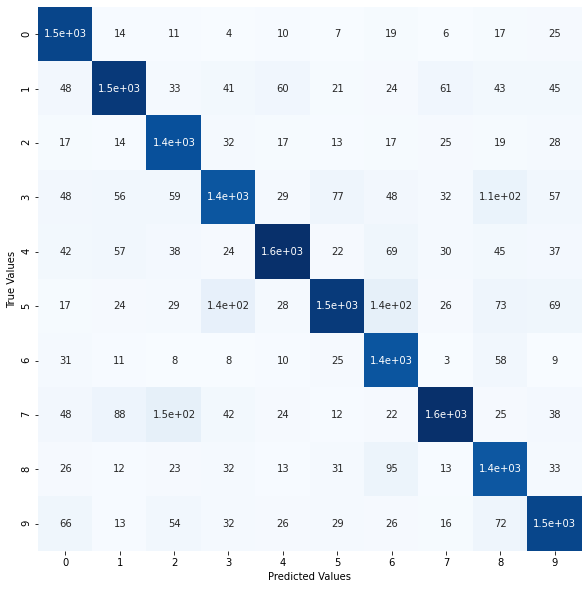

In [41]:
fig = plt.figure(figsize = (10,10))

y_pred_bn = svhn_model_bn.predict(X_test)

y_pred_bn = np.argmax(y_pred_bn, 1) #decode predicted labels
y_test_bn = np.argmax(y_test, 1) #decode labels

mat_bn = confusion_matrix(y_test_bn, y_pred_bn)

sns.heatmap(mat_bn.T, square = True, annot = True, cbar = False, cmap = plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

As we can see that the model (neural network with a weight initializer) has an accuracy of around 81.58%, so we have a quite huge improvement over the simple neural model.

From the classification matrix we can see that although the model predicts correctly for most of the digits, it also predicts some images incorrectly for every labels like 100 images as 8 when it actually was 3, 140 images as 3 when actually it was 5, 140 images as 6 when actually it was 5, 150 images as 2 when actually it was 7.  

Thus, from this exercise we can decipher the following points:
- We started creating model using **RELU** activation function and **Adam** optimizer which gave us an accuracy of 9.5% and a loss of 2.30. Both the parameters are quite undesirable.
- Then we hopped on some more complex models where we tunned the parameters (or hyperparameters):
- Training a model with **learning rate = 0.0001** - It gave us an accuracy of 80.91% and a loss of 0.67
- Training a model with **weight_initialization = 'he_normal'** - It gave us an accuracy of 82.87% and loss of 0.62
- Training a model with **a decaying learning rate** - It gave us an accuracy of 78.16% and a loss of 0.74 (a bit underperformance if compared to the last two models but still way better then the first model)
- Training a modle with **having layer of BatchNormalization** - It gave us an accuracy of 81.59% and a loss of 0.61
- From the model(s) that we had drawn here it is clear that one or other model has faced a problem in identifying all the images especially 3 which has been confused as 5 (or in some case vice-versa) etc.


Thus, we can say that:
- Creating a simple neural network is never a good idea as it will have a very low accuracy and a high loss value
- We should always create a model with some amount of tuning of parameters (or hyperparameters) as this will led to a significant higher accuracy and a lower loss.